In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
from ipywidgets import interact 
import seaborn as sns
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import numpy as np

In [2]:
torch.__version__

'2.1.0'

In [ ]:
pd.read_csv('Amazon.csv')

# Loading Data

In [4]:
train_df, test_df = pd.read_csv('Amazon_Reviews_Train.csv'), pd.read_csv('Amazon_Reviews_Test.csv')

In [5]:
train_df

,brand,primaryCategories,reviews.numHelpful,reviews.rating,reviews.text
0,2,Health & Beauty,NaN,4,Amazon's batteries are great. I've had no prob...
1,2,Health & Beauty,NaN,4,always need batteries
2,0,Electronics,0.0,3,It's pretty good for what it is designed to do...
3,0,Electronics,0.0,3,I love it it comes with a 12 month kids subscr...
4,0,Electronics,0.0,3,"For the price, it is quite a nice tablet. I mu..."
...,...,...,...,...,...
5995,0,Electronics,0.0,3,Bought for wife who is not into the techie wor...
5996,0,Electronics,0.0,3,I thought it would be good for my 2year old he...
5997,2,Health & Beauty,NaN,0,Wrong Item
5998,0,"Electronics,Media",16.0,3,"I got oasis yesterday, very lighweight compare..."


In [7]:
test_df.shape

(2000, 5)

In [12]:
from sklearn.model_selection import train_test_split
initial_labeled_set, pool = train_test_split(train_df, test_size=0.95, stratify=train_df['reviews.rating'])

In [18]:
num_labels = 5
id_to_label = {
    0: "Bad",
    1: "Good",
    2: "Neutral",
    3: "Very Good",
    4: "Excellent"
}

label_to_id = {value : key for key , value in  id_to_label.items()}




# Spliting Data into train_encodings, test_encodings

In [20]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [24]:
train_encodings = tokenizer(train_df['reviews.text'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['reviews.text'].to_list(), truncation=True, padding=True)
train_labels = train_df['reviews.rating'].to_list()
test_labels = test_df['reviews.rating'].to_list()

In [26]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, id2label = id_to_label, label2id = label_to_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TrainingArguments, Dataloader, Metrics are needed to construct this Fine-tune the model

In [27]:
training_args = TrainingArguments(
    output_dir='./BERTModel2',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,  # Reduced number of epochs.
    per_device_train_batch_size=5,  # Reduced batch size for training.
    per_device_eval_batch_size=20,  # Reduced batch size for evaluation.
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,  # Enable mixed precision training.
)


In [28]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)

In [29]:
def compute_metrics(pred):
    
   
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Calling our Dataloader

In [30]:
train_dataloader = DataLoader(train_encodings,train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [31]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

#  Evaluate the prediction accuracy of our model on the dataset without training or fine-tuning it

In [32]:
predictions = trainer.predict(test_dataloader)


  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
predicted_labels = predictions.predictions.argmax(axis=1)


In [35]:
accuracy = accuracy_score(test_df['reviews.rating'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))

accuracy 10.0% 


## An Active Learning Approach Based On Uncertain Sampling

In [36]:
initial_labeled_set.head() # so we fine_tune with the inital_labeled data

,brand,primaryCategories,reviews.numHelpful,reviews.rating,reviews.text
2175,2,Health & Beauty,NaN,4,"Great batteries, great price, fast shipping."
3573,2,Health & Beauty,NaN,3,good value and time will tell if they last as ...
5196,2,Health & Beauty,NaN,3,"Some of the batteries were already dead, but n..."
3258,0,Electronics,1.0,3,After dropping my Kindle with a keyboard (not ...
5642,2,Health & Beauty,NaN,1,Only 3 worked out of the entire pack.


In [37]:
initial_labeled_set.shape

(300, 5)

# 

In [38]:
def entropy_for_each_row(class_probabilities):
    """ Calculate entropy for each row in the array """
    return -tf.reduce_sum(class_probabilities * tf.math.log(class_probabilities),axis=1)

In [48]:
def predict_and_calculate_entropy(data):
    
    ''' 
    Predict and Calculate Entropy
    
    This function makes predictions using a pre-trained BERT model, calculates the entropy (uncertainty) of these predictions, 
    and creates a DataFrame containing relevant information.
    
    Args:
        data (DataFrame): A Pandas DataFrame containing text data and associated labels. The DataFrame should have 
        columns 'example' for text data and 'label' for labels.

    Returns:
        final_df (DataFrame): A Pandas DataFrame containing the following columns:
            - 'example': The original text data.
            - 'predicted_Label': The predicted class labels based on the model's predictions.
            - 'predicted_Probability': The maximum predicted probability for each instance.
            - 'Entropy': The calculated entropy (uncertainty) for each instance.
            - 'label': The original labels from the input data.
    ''' 

    
            
    # Sample the Data 
    data_encodings = tokenizer(data['reviews.text'].to_list(), truncation=True, padding=True)
    dataloader = DataLoader(data_encodings, data['reviews.rating'].to_list())

    # Make predictions with class_probabilities and calculate entropy (uncertainty) 
    predictions = trainer.predict(dataloader)
    prediction_probabilities = tf.constant(predictions.predictions)

    # Predicted Labels 
    predicted_labels = predictions.predictions.argmax(axis=1)

    
    # Prediction probabilities, returning the highest probability for each instance
    prediction_probabilities_max = np.amax(prediction_probabilities, axis=1)

    # Calculate entropy for each instance
    entropies = entropy_for_each_row(tf.nn.softmax(prediction_probabilities))

    entropy_df = pd.DataFrame(
        {'reviews.text' : data['reviews.text'].to_list(),
         'predicted_Label': predicted_labels,
         'predicted_Probability': prediction_probabilities_max,
         'Entropy': entropies},
        index=data.index
    )

    final_df = pd.concat([data['reviews.rating'], entropy_df], axis=1)

    return final_df.sort_values(by=['Entropy'],ascending=False)


# Simulated Active Learning

In [43]:
initial_labeled_set2 = test_df.head(150)

In [44]:
initial_labeled_set2

,brand,primaryCategories,reviews.numHelpful,reviews.rating,reviews.text
0,2,Health & Beauty,NaN,3,A lot of battery for the buck.
1,0,Electronics,0.0,3,Great tablet for toddlers. Easy yet fun. I pur...
2,2,Health & Beauty,NaN,0,I love Amazon and Amazon products but....MAJOR...
3,2,Health & Beauty,NaN,4,Fast delivery of product as advertised.
4,2,Health & Beauty,NaN,3,"Battery life is equivalent to name-brand, mid-..."
...,...,...,...,...,...
145,0,Electronics,0.0,3,So I think I would have rated 5 stars however ...
146,0,"Toys & Games,Electronics",0.0,3,This is a great tablet for young children. Our...
147,2,Health & Beauty,NaN,3,These are great! They work well. A great price...
148,2,Health & Beauty,NaN,4,Long lasting in a high drain device


In [49]:
hundreds_rows_pred = predict_and_calculate_entropy(initial_labeled_set2)

  0%|          | 0/8 [00:00<?, ?it/s]

In [50]:
hundreds_rows_pred

,reviews.rating,reviews.text,predicted_Label,predicted_Probability,Entropy
62,2,I'll be paying extra for energizers they last ...,2,0.128662,1.580889
12,4,They work,2,0.401123,1.563986
53,4,great value,2,0.429199,1.560337
59,3,For the price it's a bargain. This is a perfec...,2,0.183228,1.557272
80,4,satisfied,2,0.464600,1.551230
...,...,...,...,...,...
32,4,Great bargain.,2,0.679688,1.441965
89,4,Seem to last. Can't beat price point.,2,0.707520,1.430040
130,4,Great batteries.,2,0.725586,1.430027
106,3,PURCHASED THIS WITH A STORE CREDIT AND LIKE IT...,2,0.718750,1.429536


# Active Learning

In [52]:
# Initialize empty lists to store metrics for each iteration
accuracy_list = []
precision_list = []
recall_list = []
loss_list = []
x_labels = []
n = 0

for iteration in range(15):
    n += 10
    print(n)
    initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:n]['reviews.text'].to_list(), truncation=True, padding=True)
    initial_labeled_labels = hundreds_rows_pred[0:n]['reviews.rating'].to_list()
    initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)

   
    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= initial_labeled_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()

    print('eval_Accuracy :',metrics['eval_Accuracy'])

    accuracy_list.append(metrics['eval_Accuracy'])
    precision_list.append(metrics['eval_Precision'])
    recall_list.append(metrics['eval_Recall'])
    loss_list.append(metrics['eval_loss'])
    x_labels.append(n)



10


  0%|          | 0/6 [00:00<?, ?it/s]

{'train_runtime': 1.329, 'train_samples_per_second': 22.574, 'train_steps_per_second': 4.515, 'train_loss': 1.7027344703674316, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.1005
20


  0%|          | 0/12 [00:00<?, ?it/s]

{'train_runtime': 1.4665, 'train_samples_per_second': 40.913, 'train_steps_per_second': 8.183, 'train_loss': 1.7119628588358562, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.101
30


  0%|          | 0/18 [00:00<?, ?it/s]

{'train_runtime': 2.2644, 'train_samples_per_second': 39.745, 'train_steps_per_second': 7.949, 'train_loss': 1.6363336775037978, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.1005
40


  0%|          | 0/24 [00:00<?, ?it/s]

{'train_runtime': 3.2889, 'train_samples_per_second': 36.486, 'train_steps_per_second': 7.297, 'train_loss': 1.513810157775879, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.1825
50


  0%|          | 0/30 [00:00<?, ?it/s]

{'train_runtime': 3.7755, 'train_samples_per_second': 39.73, 'train_steps_per_second': 7.946, 'train_loss': 1.281448491414388, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.5185
60


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_runtime': 4.9679, 'train_samples_per_second': 36.233, 'train_steps_per_second': 7.247, 'train_loss': 1.0105875862969294, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.5345
70


  0%|          | 0/42 [00:00<?, ?it/s]

{'train_runtime': 5.791, 'train_samples_per_second': 36.263, 'train_steps_per_second': 7.253, 'train_loss': 0.85432007199242, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.493
80


  0%|          | 0/48 [00:00<?, ?it/s]

{'train_runtime': 6.4989, 'train_samples_per_second': 36.929, 'train_steps_per_second': 7.386, 'train_loss': 0.7551875114440918, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.5685
90


  0%|          | 0/54 [00:00<?, ?it/s]

{'loss': 0.5435, 'learning_rate': 2.4e-05, 'epoch': 2.78}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 1.2118996381759644, 'eval_Accuracy': 0.5795, 'eval_F1': 0.2866460250250227, 'eval_Precision': 0.6958476619278903, 'eval_Recall': 0.292367476445403, 'eval_runtime': 31.7021, 'eval_samples_per_second': 63.087, 'eval_steps_per_second': 3.154, 'epoch': 2.78}
{'train_runtime': 39.012, 'train_samples_per_second': 6.921, 'train_steps_per_second': 1.384, 'train_loss': 0.5510782665676541, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.5095
100


  0%|          | 0/60 [00:00<?, ?it/s]

{'loss': 0.5097, 'learning_rate': 2.3000000000000003e-05, 'epoch': 2.5}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 1.2427372932434082, 'eval_Accuracy': 0.597, 'eval_F1': 0.35152337936905736, 'eval_Precision': 0.6338065981806693, 'eval_Recall': 0.3422501275394302, 'eval_runtime': 31.7646, 'eval_samples_per_second': 62.963, 'eval_steps_per_second': 3.148, 'epoch': 2.5}
{'train_runtime': 39.9814, 'train_samples_per_second': 7.503, 'train_steps_per_second': 1.501, 'train_loss': 0.4744236946105957, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.613
110


  0%|          | 0/66 [00:00<?, ?it/s]

{'loss': 0.2774, 'learning_rate': 2.35e-05, 'epoch': 2.27}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 1.1778534650802612, 'eval_Accuracy': 0.6145, 'eval_F1': 0.4141126689738347, 'eval_Precision': 0.5363550703769286, 'eval_Recall': 0.42494667268338804, 'eval_runtime': 31.8365, 'eval_samples_per_second': 62.821, 'eval_steps_per_second': 3.141, 'epoch': 2.27}
{'train_runtime': 41.0613, 'train_samples_per_second': 8.037, 'train_steps_per_second': 1.607, 'train_loss': 0.2533946362408725, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.6235
120


  0%|          | 0/72 [00:00<?, ?it/s]

{'loss': 0.2559, 'learning_rate': 2.35e-05, 'epoch': 2.08}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 1.4325240850448608, 'eval_Accuracy': 0.6275, 'eval_F1': 0.41284416060664597, 'eval_Precision': 0.5835545504387749, 'eval_Recall': 0.397293461592509, 'eval_runtime': 31.9805, 'eval_samples_per_second': 62.538, 'eval_steps_per_second': 3.127, 'epoch': 2.08}
{'train_runtime': 42.9942, 'train_samples_per_second': 8.373, 'train_steps_per_second': 1.675, 'train_loss': 0.23594063520431519, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.6345
130


  0%|          | 0/78 [00:00<?, ?it/s]

{'loss': 0.1702, 'learning_rate': 2.4e-05, 'epoch': 1.92}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 1.870599389076233, 'eval_Accuracy': 0.602, 'eval_F1': 0.416487953115163, 'eval_Precision': 0.5828593066836617, 'eval_Recall': 0.40986060437414495, 'eval_runtime': 31.838, 'eval_samples_per_second': 62.818, 'eval_steps_per_second': 3.141, 'epoch': 1.92}
{'train_runtime': 42.8445, 'train_samples_per_second': 9.103, 'train_steps_per_second': 1.821, 'train_loss': 0.14400280133271828, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.638
140


  0%|          | 0/84 [00:00<?, ?it/s]

{'loss': 0.1311, 'learning_rate': 2.4e-05, 'epoch': 1.79}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 1.6262563467025757, 'eval_Accuracy': 0.6175, 'eval_F1': 0.4784968853270664, 'eval_Precision': 0.4978277113279296, 'eval_Recall': 0.47741440811074354, 'eval_runtime': 31.8524, 'eval_samples_per_second': 62.79, 'eval_steps_per_second': 3.139, 'epoch': 1.79}
{'train_runtime': 43.8199, 'train_samples_per_second': 9.585, 'train_steps_per_second': 1.917, 'train_loss': 0.10633389155069987, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.622
150


  0%|          | 0/90 [00:00<?, ?it/s]

{'loss': 0.0514, 'learning_rate': 2.4e-05, 'epoch': 1.67}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 1.9406825304031372, 'eval_Accuracy': 0.6345, 'eval_F1': 0.47205210569114053, 'eval_Precision': 0.512751429603195, 'eval_Recall': 0.46806211037246204, 'eval_runtime': 31.8559, 'eval_samples_per_second': 62.783, 'eval_steps_per_second': 3.139, 'epoch': 1.67}
{'train_runtime': 44.4966, 'train_samples_per_second': 10.113, 'train_steps_per_second': 2.023, 'train_loss': 0.0772996187210083, 'epoch': 3.0}


  0%|          | 0/100 [00:00<?, ?it/s]

eval_Accuracy : 0.6075


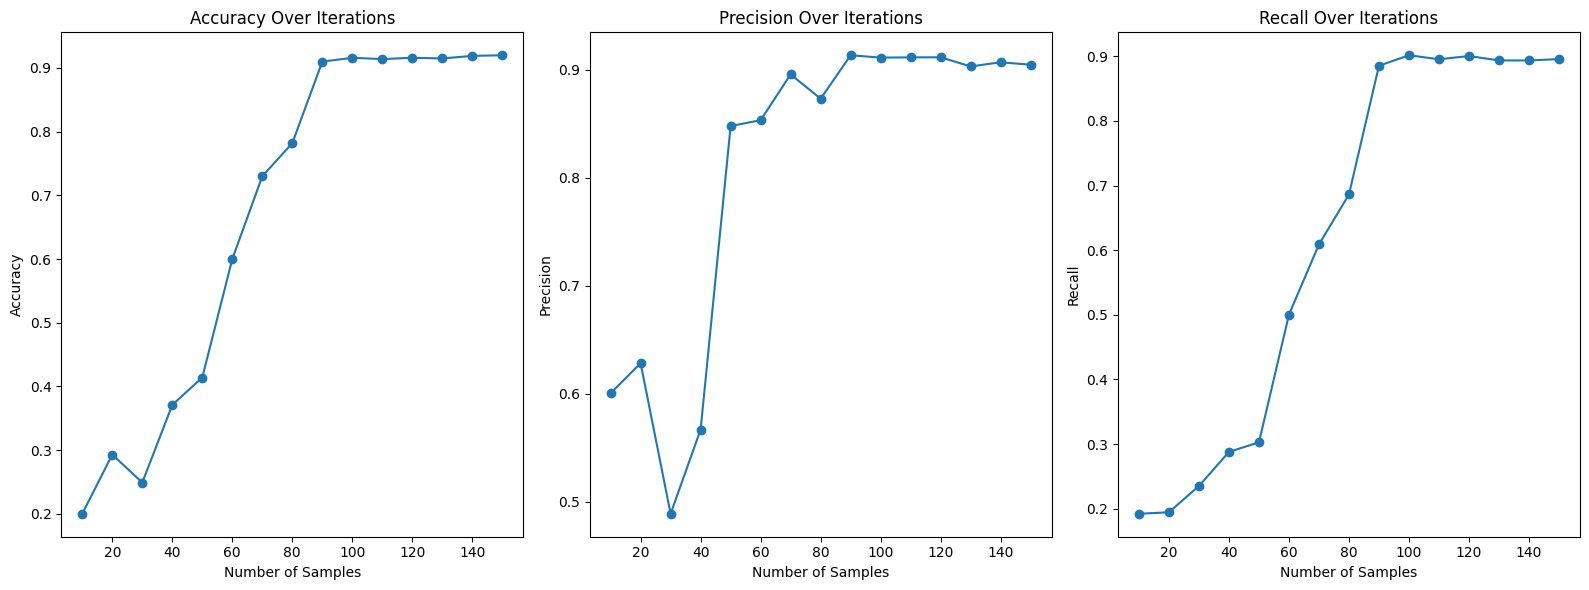

In [31]:
# Plot the metrics
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(x_labels, accuracy_list, marker='o')
plt.title('Accuracy Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(x_labels, precision_list, marker='o')
plt.title('Precision Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(x_labels, recall_list, marker='o')
plt.title('Recall Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [53]:
test_df

,brand,primaryCategories,reviews.numHelpful,reviews.rating,reviews.text
0,2,Health & Beauty,NaN,3,A lot of battery for the buck.
1,0,Electronics,0.0,3,Great tablet for toddlers. Easy yet fun. I pur...
2,2,Health & Beauty,NaN,0,I love Amazon and Amazon products but....MAJOR...
3,2,Health & Beauty,NaN,4,Fast delivery of product as advertised.
4,2,Health & Beauty,NaN,3,"Battery life is equivalent to name-brand, mid-..."
...,...,...,...,...,...
1995,0,Electronics,0.0,3,I exchanged a highly unsatisfactory Insignia u...
1996,0,Electronics,0.0,3,we're early in the stages of home smartness bu...
1997,0,Electronics,0.0,3,my grandson had one and likes it. so i bought ...
1998,0,Electronics,4.0,3,This is a nice bare-bones reading device. Easy...


In [55]:
predictions = trainer.predict(test_dataloader)
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(test_df['reviews.rating'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))


  0%|          | 0/100 [00:00<?, ?it/s]

accuracy 61.0% 


In [56]:
bert_pred_df = pd.DataFrame({'Bert_Pred' : predicted_labels, 'reviews.rating' : test_df['reviews.rating'].to_list() })

In [57]:
bert_pred_df.to_csv('Amazon_Bert_Pred.csv',index=False)

In [58]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix

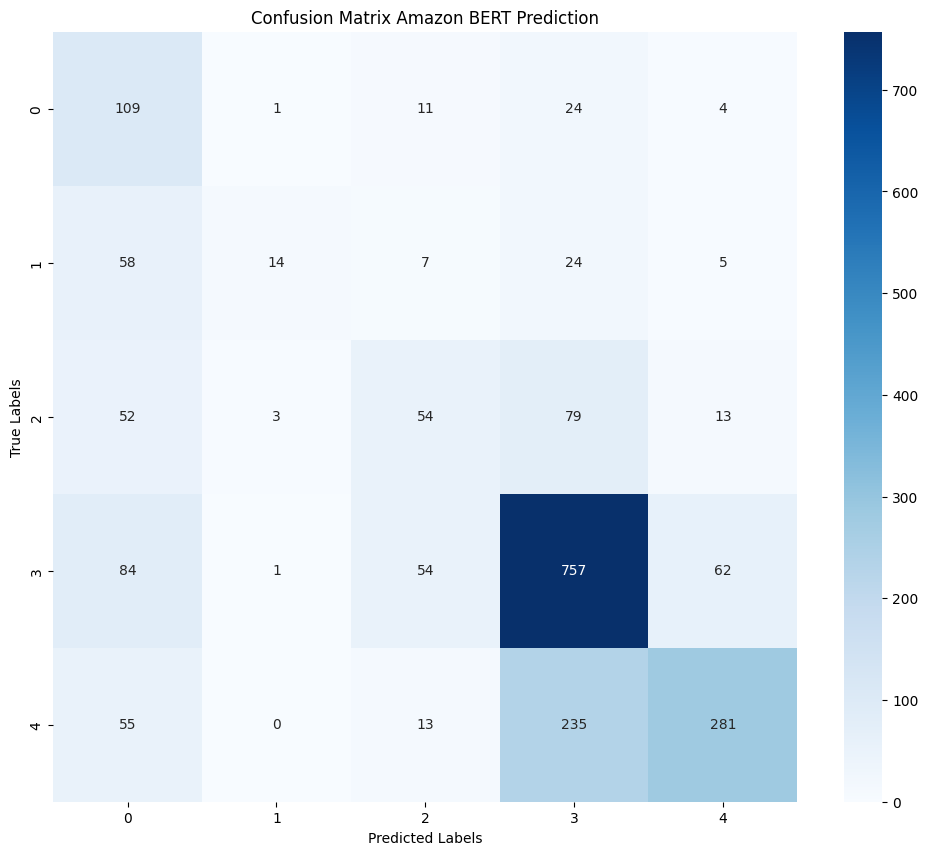

In [60]:
# Compute the confusion matrix
cm = confusion_matrix(test_df['reviews.rating'].to_list(),predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Amazon BERT Prediction')


# Save the confusion matrix as an image
plt.savefig('confusion_matrix.png')
plt.show()

In [61]:
import csv


# Combine the lists into a list of tuples
data = list(zip(x_labels, accuracy_list, precision_list, recall_list, loss_list))

# Specify the file name
csv_file_name = "Amazon_Label_Accuracies.csv"

# Write the data to a CSV file
with open(csv_file_name, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    csv_writer.writerow(['Labels', 'accuracy', 'precision', 'recall', 'loss'])
    
    # Write the data
    csv_writer.writerows(data)

print(f"CSV file '{csv_file_name}' has been created.")

CSV file 'Amazon_Label_Accuracies.csv' has been created.
